## 基础回归模型：预测汽车燃油效率Auto MPG

In [1]:
import sys
import os
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns


%matplotlib inline

print("python version: ", sys.version_info)
for module in np, mpl, tf, keras, pd, sns:
    print(module.__name__, "version: ", module.__version__)
    
seed = 10383

python version:  sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
numpy version:  1.16.0
matplotlib version:  3.0.3
tensorflow version:  2.3.0
tensorflow.keras version:  2.4.0
pandas version:  0.24.2
seaborn version:  0.11.0


### 1. Auto MPG 数据集

#### 1.1 获取数据

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/vccccccc/.keras/datasets/auto-mpg.data'

In [3]:
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]
raw_dataset = pd.read_csv(
    dataset_path,
    names=column_names,
    na_values = "?",
    comment="\t",
    sep=" ",
    skipinitialspace=True,
)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### 4.2 数据清洗

数据集中包括一些未知值。

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

为了保证这个初始示例的简单性，删除这些行。

In [5]:
dataset = dataset.dropna()

"Origin" 列实际上代表分类，而不仅仅是一个数字。所以把它转换为独热码 （one-hot）:

In [6]:
origin = dataset.pop("Origin")

In [7]:
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin == 2) * 1.0
dataset["Japan"] = (origin == 3) * 1.0  
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### 1.3 拆分数据集

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=seed)
test_dataset = dataset.drop(train_dataset.index)

#### 1.4 数据检查

快速查看训练集中几对列的联合分布。

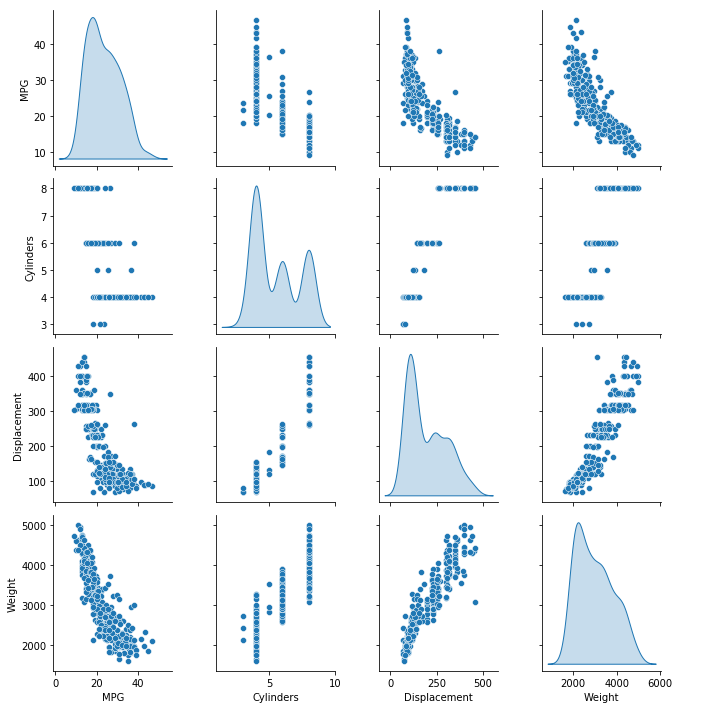

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

也可以查看总体的数据统计:

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.522293,1.701666,3.0,4.00,5.0,8.00,8.0
Displacement,314.0,195.979299,103.771962,68.0,105.00,151.0,293.25,455.0
Horsepower,314.0,104.777070,38.698573,46.0,75.25,95.0,129.00,230.0
Weight,314.0,2988.054140,839.644494,1613.0,2223.75,2867.5,3611.00,4997.0
Acceleration,314.0,15.549363,2.709706,8.5,13.80,15.5,17.30,23.7
Model Year,314.0,75.993631,3.738235,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.636943,0.481649,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.168790,0.375164,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.194268,0.396267,0.0,0.00,0.0,0.00,1.0


#### 1.5 从数据集中分离标签

In [11]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

#### 1.6 数据归一化

In [12]:
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### 2. 模型

#### 2.1 构建模型

In [13]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.RMSprop(0.001)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

In [14]:
model = build_model()

#### 2.2 检查模型

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.03166941],
       [-0.36707467],
       [-0.44236594],
       [-0.52960074],
       [-0.36092246],
       [-0.38247985],
       [-0.09795389],
       [-0.32179928],
       [-0.4367485 ],
       [-0.04536553]], dtype=float32)

#### 2.3 训练模型

对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。

In [17]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print("")
        print(".", end="")


EPOCHS = 1000

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[PrintDot()],
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [18]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.021078,0.966645,2.021078,10.571566,2.207678,10.571566,995
996,1.902576,0.925578,1.902576,10.194715,2.227073,10.194715,996
997,1.806594,0.922875,1.806594,10.706547,2.175400,10.706547,997
998,1.935402,0.936456,1.935402,11.016437,2.218808,11.016437,998
999,1.885673,0.935481,1.885673,10.539564,2.189966,10.539564,999


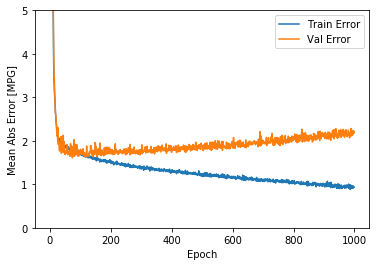

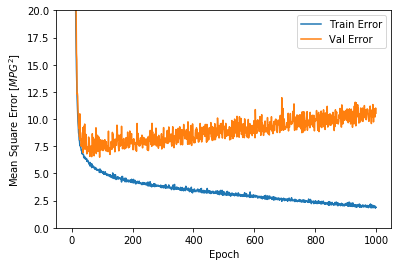

In [19]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [MPG]")
    plt.plot(hist["epoch"], hist["mae"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
    plt.ylim([0, 5])
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    plt.plot(hist["epoch"], hist["mse"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
    plt.ylim([0, 20])
    plt.legend()
    plt.show()


plot_history(history)

#### 2.4 early stopping


........................................................

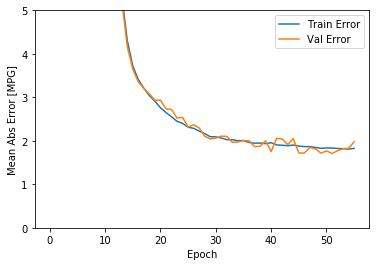

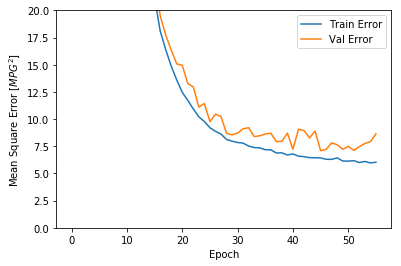

In [20]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stop, PrintDot()],
)

plot_history(history)

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 9.5104 - mae: 2.3102 - mse: 9.5104
Testing set Mean Abs Error:  2.31 MPG


#### 2.5 预测

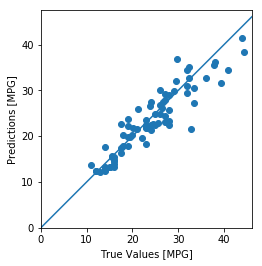

In [22]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

查看误差分布

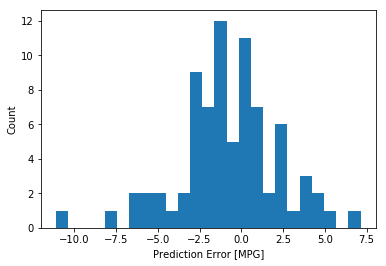

In [23]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布，但我们可以推断出，这是因为样本的数量很小所导致的。

### 3. 总结

1. 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）。  
2. 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）。  
3. 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。  
4. 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合。
5. 早期停止是一种防止过度拟合的有效技术。  